# PROJECT: Course Optimization for Data Science
## Optimization strategies for anomaly detection
## with One class Support Vector Machines (OCSVM)

Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- derive the dual for the one-class SVM model
- implement a one-class SVM using a blackbox convex toolbox (cvxopt in Python)
- implement your own solvers with: Proximal gradient, Coordinate Descent, Quasi-Newton
- Present a clear benchmark of the different strategies on small and medium scale datasets


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 7th of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "xiangnan"
ln1 = "yue"
fn2 = "junfeng"
ln2 = "chen"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_yue_xiangnan_and_chen_junfeng.ipynb


Some imports

In [2]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt


## Important:

For Part 0 to Part 2 of the project you will need a working install of `cvxopt`.
You may struggle a bit to set it up.
The simplest way of getting it is by typing 

`conda install cvxopt`

or

`pip install cvxopt`

if you have `conda` or `pip` installed on your laptop.
If you **struggle too much please
contact us**.

In [3]:
# try import convex optiver
import cvxopt

## Part 0: One-class SVM

The original formulation of the One-Class SVM introduced by Schölkopf [1] is given by

$$
    (\mathcal{P}): \left\{
	\begin{aligned}
	\min_{w, \rho, \xi} & \quad \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \xi_i \\
	\text{s.t.} & \quad \langle w, x_i \rangle \geq \rho - \xi_i \quad 1 \leq i \leq n \\
	& \quad \xi_i \geq 0 \quad 1 \leq i \leq n
	\end{aligned}
    \right.
$$

where $\nu \in (0, 1]$ is a user-specified parameter controlling the proportion of outliers and the proportion of support vectors.

Getting rid of the slack variables $\xi_i, 1 \leq i \leq n$ one can also obtain the following equivalent optimization problem

$$
	\min_{w, \rho} \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \max(0, \rho - \langle w, x_i \rangle) \, .
$$

The idea is that the lower is $\langle w, x_i \rangle$ is the more $x_i$ is an anomaly and if $\langle w, x_i \rangle \geq \rho$ then the model predicts the sample is normal. $\langle w, x_i \rangle$ corresponds to the decision function and $\textrm{sign}(\langle w, x_i \rangle - \rho)$ as the prediction (1 means normal sample).

[1] Schölkopf et al. Estimating the support of a high-dimensional distribution. Neural Computation. 2001

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
      <li>Justify that the problem $(\mathcal{P})$ is convex.</li>
    </ul>
</div>

ANSWER HERE
problem P is convex because the objective function can be written as f(x) + g(x), where $f(x) = \frac{1}{2}\Vert w \Vert^2$, and g(x) is an affine function. We know that quadratic function  and affine functions are convex. The constraint gives a set obtained by taking the intersect of convex sets, since both $\quad \langle w, x_i \rangle \geq \rho - \xi_i $ and $\xi_i \geq 0 $ give convex set.

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
      <li>
      By looking at the saddle points of the Lagrangian $\mathcal{L}(w, \rho, \mu)$ of $\mathcal{P}$, $\mu \in \mathbb{R}_+^n$, show that the dual problem $(\mathcal{D})$ can be written as:
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu
 \\
 \mathrm{s.t.}& \mu^{\top}1_n = 1
 \\
 \mathrm{and}& 0 \leq \mu \leq \frac{1}{\nu n}
 \end{array}
 \right .
$$

with

$$
 G = \begin{bmatrix}x_{1}^{\top} \\ \vdots \\ x_{n}^{\top}\end{bmatrix}
$$

and $1_n = (1, \dots, 1) \in \mathbb{R}^n$.
    </li>
    </ul>
</div>

We will **assume here qualification of the contraints** and that **strong duality holds**.

**Remark:** The problem $(\mathcal{D})$ is a *quadratic program* (QP) for which their exist off-the-shelf techniques. See below.

ANSWER HERE
Proof: 

We first write out the Lagrangian Formular for the problem P:

$L(w, \rho, \xi, \phi_{1i}, \phi_{2i} \quad; 1 \leq i \leq n ) = $

$\quad \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \xi_i + \sum_{i=1}^n \phi_{1i} ( \rho - \xi_i - \langle w, x_i \rangle ) - \sum_{i=1}^n \phi_{2i} \xi_i - \iota_{R_+}(\phi_1, \phi_2) $

Now we can write our problem D as following:

$$ 
\max_{\phi_{1i}, \phi_{2i}} \min_{w, \rho, \xi_i}
\quad \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \xi_i + \sum_{i=1}^n \phi_{1i} ( \rho - \xi_i - \langle w, x_i \rangle ) - \sum_{i=1}^n \phi_{2i} \xi_i - \iota_{R_+}(\phi_1, \phi_2)
\\
$$

We then list all the derivatives with respect to variables $w, \rho, \xi_i$ :
$$
\partial_{w} L(w, \rho, \xi, \phi_{1i}, \phi_{2i}) = w - \sum_{i=1}^n \phi_{1i} x_{i} = 0
\\
\partial_{\rho} L(w, \rho, \xi, \phi_{1i}, \phi_{2i}) = -1 + \sum_{i=1}^n \phi_{1i} = 0
\\
\partial_{\xi_i} L(w, \rho, \xi, \phi_{1i}, \phi_{2i}) = \frac{1}{vn} - \phi_{1i} - \phi_{2i} = 0
$$

Let $\mu = \phi_1$, and use the above three equality in the problem D:

$$ 
\max_{\phi_{1i}, \phi_{2i}}
\quad \frac{1}{2}\Vert \sum_{i=1}^n \phi_{1i} x_{i} \Vert^2 + (\sum_{i=1}^n \phi_{1i} - 1) \rho + \sum_{i=1}^n (\frac{1}{\nu n} - \phi_{1i} - \phi_{2i}) \xi_i + \sum_{i=1}^n \phi_{1i} ( - \langle w, x_i \rangle ) - \iota_{R_+}(\phi_1, \phi_2)
\\
$$

We got the following:

$$
(\mathcal{D}): 
 \left\{
\begin{array}{lll}
\max_{\mu_{i}, \phi_{2i}} &
\quad \frac{1}{2}\Vert \sum_{i=1}^n \mu_{i} x_{i} \Vert^2 - \sum_{i=1}^n \mu_{i} ( \sum_{i=1}^n \mu_{i} x_{i} , x_i \rangle ) \quad (obj)
\\
\mathrm{s.t.}& \mu^{\top}1_n = 1
\\
and & \mu, \phi_2 \geq 0
\end{array}
\right .
$$

We can still change the objective to matrix form
$$
 \begin{array}{lll}
    (obj) & <=> \max_{\mu_{i}, \phi_{2i}}
    \quad \frac{1}{2} \langle \sum_{i=1}^n \mu_{i} x_{i}, \sum_{j=1}^n \mu_{j} x_{j} \rangle  - \sum_{i=1}^n \mu_{i} ( \sum_{i=1}^n \mu_{i} x_{i} , x_i \rangle )
    \\
    & <=> \max_{\mu_{i}, \phi_{2i}}
    \quad - \frac{1}{2} \langle \sum_{i=1}^n \mu_{i} x_{i}, \sum_{j=1}^n \mu_{j} x_{j} \rangle
    \\
    & <=> \max_{\mu_{i}, \phi_{2i}}
    \quad - \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n \langle \mu_{i} x_{i},  \mu_{j} x_{j} \rangle
    \\
    & <=> \max_{\mu_{i}, \phi_{2i}}
    \quad - \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n \mu_{i} \mu_{j} \langle  x_{i},   x_{j} \rangle
    \\
    & <=> \min_{\mu_{i}, \phi_{2i}}
    \quad \frac{1}{2}\mu^{\top}GG^{t}\mu
 \end{array}
$$

also note that with the 3rd equality above, we can replace $\phi_2$ by $\mu$

$$
 \mu, \phi_2 \geq 0 <=> \mu, -\mu + \frac{1}{vn} \overrightarrow{1} \geq 0
$$

So we conclude with the following problem D:
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu
 \\
 \mathrm{s.t.}& \mu^{\top}1_n = 1
 \\
 \mathrm{and}& 0 \leq \mu \leq \frac{1}{\nu n}
 \end{array}
 \right .
$$

<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
     <li>Justify that given the estimated $\mu$, the prediction function for a new sample $x$ (-1 if anomaly else 1) is given by:
        $$
        y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i x_i^\top x - \rho) \enspace .
        $$
        The vector $w$ is therefore equal to $\sum_{i=1}^{n} \mu_i x_i$
    </li>
    </ul>
</div>

ANSWER HERE

According to the proof above, $\partial_{w} L(w, \rho, \xi, \phi_{1i}, \phi_{2i}) = w - \sum_{i=1}^n \phi_{1i} x_{i} = 0$,
 then we have
$y = \textrm{sign}(\langle w, x \rangle - \rho)$ as the prediction (1 means normal sample)

the lower is $\langle w, x \rangle$ , the more $x_i$ is an anomal and if $\langle w, x \rangle \geq \rho$ then the model predicts the sample is normal.

Intuitively, $\rho$ is the normal distance from the boundary, and if the point distance with the boudary is less than $\rho$, it's within the error region or on the wrong side. So the point is regarded as abnormal

## Part 1: Implementation of solver using cvxopt

Let's make a toy dataset in dimension 2. When using a linear kernel we need all samples to have positive values and the outliers to be close to the origin.

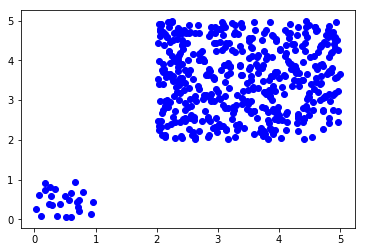

In [4]:
def make_dataset(n_samples, contamination=0.05, random_state=42):
    rng = np.random.RandomState(random_state)
    X_inliers = rng.uniform(low=2, high=5, size=(int(n_samples * (1 - contamination)), 2))
    X_outliers = rng.uniform(low=0, high=1, size=(int(n_samples * contamination), 2))
    X = np.concatenate((X_inliers, X_outliers), axis=0)
    rng.shuffle(X)
    return X

X = make_dataset(500)
plt.scatter(X[:, 0], X[:, 1], color='b');

- The following function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} P x + q^\top x
  \\
   & \textrm{s.t.}\; A x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

See documentation: http://cvxopt.org/userguide/coneprog.html#quadratic-programming

In [5]:
import cvxopt

def qp(P, q, A, b, C, verbose=True):
    # Gram matrix
    n = P.shape[0]
    P = cvxopt.matrix(P)
    q = cvxopt.matrix(q)
    A = cvxopt.matrix(A)
    b = cvxopt.matrix(b)
    
    # as the qp take Gx < h
    G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                     np.diag(np.ones(n))], axis=0))
    h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(P, q, G, h, A, b, solver='mosec')
 
    return np.ravel(solution['x'])

Definition of the linear kernel:

In [6]:
def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K

**Remark:** You can use `sklearn.metrics.pairwise_distances` to avoid the for loops and make it faster.

<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
      <li>Modify the following cell to solve the One-Class SVM dual problem.</li>
    </ul>
</div>

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu
 \\
 \mathrm{s.t.}& \mu^{\top}1_n = 1
 \\
 \mathrm{and}& 0 \leq \mu \leq \frac{1}{\nu n}
 \end{array}
 \right .
$$

In [7]:
np.zeros(3).reshape(1, -1)

array([[ 0.,  0.,  0.]])

In [8]:
# TODO
def ocsvm_solver(K, nu=0.1):
    n = np.shape(K)[0]
    P = K
    q = np.zeros(n)
    A = np.ones(n).reshape(1, -1)
    b = 1.
    C = 1/(nu*n)
    mu = qp(P, q, A, b, C, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

K = kernel(X, X)

# Uncomment the following lines when your ocsvm_solver is completed:
mu_support, idx_support = ocsvm_solver(K)
print("Number of support vectors: %s" % idx_support.size)

Number of support vectors: 50


In [9]:
mu_support, idx_support

(array([ 0.02      ,  0.02      ,  0.02      ,  0.02      ,  0.02      ,
         0.02      ,  0.02      ,  0.02      ,  0.02      ,  0.02      ,
         0.02      ,  0.02      ,  0.02      ,  0.02      ,  0.01999908,
         0.02      ,  0.02      ,  0.02      ,  0.02      ,  0.02      ,
         0.02      ,  0.02      ,  0.02      ,  0.02      ,  0.02      ,
         0.02      ,  0.02      ,  0.02      ,  0.02      ,  0.02      ,
         0.02      ,  0.02      ,  0.02      ,  0.02      ,  0.02      ,
         0.02      ,  0.02      ,  0.02      ,  0.02      ,  0.02      ,
         0.02      ,  0.02      ,  0.02      ,  0.02      ,  0.02      ,
         0.02      ,  0.02      ,  0.02      ,  0.02      ,  0.02      ]),
 array([  2,  13,  32,  36,  42,  65,  69,  87,  94, 108, 112, 115, 127,
        183, 184, 188, 192, 212, 215, 223, 242, 261, 264, 276, 287, 294,
        296, 301, 312, 321, 323, 325, 328, 331, 360, 366, 372, 373, 384,
        385, 396, 401, 404, 405, 406, 454, 455, 4

In [10]:
np.sum(mu_support), X[idx_support].shape, type(X)

(0.99999905164344061, (50, 2), numpy.ndarray)

<div class="alert alert-success">
    <b>QUESTION 5:</b>
     <ul>
      <li>Compute w using mu.</li>
    </ul>
</div>

The vector $w$ is therefore equal to $\sum_{i=1}^{n} \mu_i x_i$

In [11]:
# TODO
w = mu_support.dot(X[idx_support])

In [12]:
w

array([ 1.37631398,  1.37252753])

<div class="alert alert-success">
    <b>QUESTION 6:</b>
     <ul>
      <li>Using complementary slackness, explain how to obtain $\rho$ from $\mu$.</li>
    </ul>
</div>

**HINT:** Use the fact that for all support vectors for which $0 < \mu_i < \frac{1}{\nu n}$ one has $w^{t}x_{i} = \rho$.

ANSWER HERE

the support vector $\mu_i$ satisfies that $\mu_i \neq 0 $ and thus $ \langle w, x_i \rangle = \rho$ by complementary slackness.

In [13]:
mu_support[np.argmin(mu_support)], mu_support

(0.019999078655170029,
 array([ 0.02      ,  0.02      ,  0.02      ,  0.02      ,  0.02      ,
         0.02      ,  0.02      ,  0.02      ,  0.02      ,  0.02      ,
         0.02      ,  0.02      ,  0.02      ,  0.02      ,  0.01999908,
         0.02      ,  0.02      ,  0.02      ,  0.02      ,  0.02      ,
         0.02      ,  0.02      ,  0.02      ,  0.02      ,  0.02      ,
         0.02      ,  0.02      ,  0.02      ,  0.02      ,  0.02      ,
         0.02      ,  0.02      ,  0.02      ,  0.02      ,  0.02      ,
         0.02      ,  0.02      ,  0.02      ,  0.02      ,  0.02      ,
         0.02      ,  0.02      ,  0.02      ,  0.02      ,  0.02      ,
         0.02      ,  0.02      ,  0.02      ,  0.02      ,  0.02      ]))

In [14]:
# TODO

def compute_rho(K, mu_support, idx_support):
    # TODO
    K_support = K[idx_support][:, idx_support]
    rho = np.max(K_support.dot(mu_support))
    
    # or you can do this :
    
    #i = np.argmin(mu_support)
    #K_support = K[idx_support[i],idx_support]
    #rho = np.dot(mu_support,K_support)
    return rho

my_compute_rho = (compute_rho(K, mu_support, idx_support)) 

In [15]:
my_compute_rho

6.7570987967128593

<div class="alert alert-success">
    <b>QUESTION 7:</b>
     <ul>
      <li>Verify that you find the same values as what scikit-learn gives. You should have the same support vectors and:


`rho = -ocsvm.intercept_[0] / (ocsvm.nu * len(K))`

and `mu_support = ocsvm.dual_coef_.ravel() / (ocsvm.nu * len(K))`</li>
    </ul>
</div>

In [16]:
from sklearn.utils.testing import assert_array_almost_equal
from sklearn.utils.testing import assert_almost_equal
from sklearn.svm import OneClassSVM

X = make_dataset(150)

ocsvm = OneClassSVM(kernel='linear', nu=0.05)
ocsvm.fit(X)

K = kernel(X, X)
mu_support, idx_support = ocsvm_solver(K, nu=ocsvm.nu)
rho = compute_rho(K, mu_support, idx_support)

# Check indices of support vectors
print(ocsvm.support_)
print(idx_support)

# Check rho
print(rho)
print(-ocsvm.intercept_[0] / (ocsvm.nu * len(K)))

# Check dual variables
print(mu_support)
print(ocsvm.dual_coef_.ravel() / (ocsvm.nu * len(K)))

# Run formal tests:
assert_array_almost_equal(ocsvm.support_, idx_support)
assert_almost_equal(rho, -ocsvm.intercept_[0] / (ocsvm.nu * len(K)))
assert_array_almost_equal(mu_support, ocsvm.dual_coef_.ravel() / (ocsvm.nu * len(K)))

[  4  23  66  72  90  92 109 113]
[  4  23  66  72  90  92 109 113]
2.16400352023
2.16400355501
[ 0.13422819  0.13422819  0.06040268  0.13422819  0.13422819  0.13422819
  0.13422819  0.13422819]
[ 0.13422819  0.13422819  0.06040268  0.13422819  0.13422819  0.13422819
  0.13422819  0.13422819]


Check your code by running the following cell:

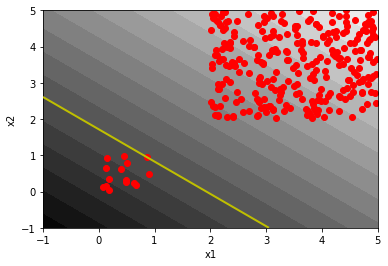

In [17]:
X = make_dataset(300)

K = kernel(X, X)
mu_support, idx_support = ocsvm_solver(K, nu=0.05)
rho = compute_rho(K, mu_support, idx_support)

def plot_ocsvm(X, mu_support, idx_support, rho, kernel=kernel):
    # Compute decision function on a grid
    X1, X2 = np.mgrid[-1:5.1:0.2, -1:5.1:0.2]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Compute dot products
    X_support = X[idx_support]
    G = kernel(X_test, X_support)
    # Compute decision function
    decision = G.dot(mu_support) - rho

    # Compute predict label
    y_pred = np.sign(decision)

    # Plot decision boundary
    plt.plot(X[:,0], X[:, 1], 'or', linewidth=2)
    Z = np.reshape(decision, (na, nb))
    plt.contourf(X1, X2, Z, 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, Z, [0], colors='y', linewidths=2, zorder=10)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-1, 5])
    plt.ylim([-1, 5])

plot_ocsvm(X, mu_support, idx_support, rho)

<div class="alert alert-success">
    <b>QUESTION 8:</b>
     <ul>
      <li>Without any implementation, can you justify if you can apply any of the algorithm, among proximal gradient, coordinate descent, stochastic gradient descent and L-BFGS to the dual problem?
      </li>
    </ul>
</div>

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu \quad (obj)
 \\
 \mathrm{s.t.}& \mu^{\top}1_n = 1 \quad (1)
 \\
 \mathrm{and}& 0 \leq \mu \leq \frac{1}{\nu n} \quad (2)
 \end{array}
 \right .
$$

ANSWER HERE

We can use proximal gradient descent method, since the objective function is a quadratic function which is convex and smooth. The constraint (1) and (2) can be written in the form of indicator function, which is convex and proximal friendly.

We can also use the coordinate descent, since the non-smooth part (the constraints) is separable with respect to coordinates and the objective function is smooth and convex

Stochastic gradient descent is not applicable, provided that the objective function is not separable with respect to observations.

L-BFGS is possible, provided that $GG^T$ is a positive definite quadratic form. The algorithm can have very good property by generating a sequence of conjugate directions and converges very quickly to the Inverse matrix of Hessian matrix of the objective function.

## Part 1: non-linear case with kernels

Another scenario is when the boundary between normal samples and outliers is not linear.

To cope with this the idea is to use kernels.

<div class="alert alert-success">
    <b>QUESTION 9:</b>
     <ul>
      <li>Denoting by $K(x_i, x_j)$ the dot product between samples show that dual problem and the decision function f(x) can be reformulated just using calls to $K$
      </li>
    </ul>
</div>

ANSWER HERE

Using the $K(x_i, x_j)$ doesn't affect the linearity of the dot product (in fact it changes only the definition of inner product by introducing a kernel). We thus conclude that if we denote $ G = (K(x_i, x_j))_{ij} $, then the dual problem (D) still holds. the decision function is $y(z) = \textrm{sign}( \sum_{i=1}^n \mu_i K(z, x_i) - \rho)$

We will use another dataset to evaluate this:

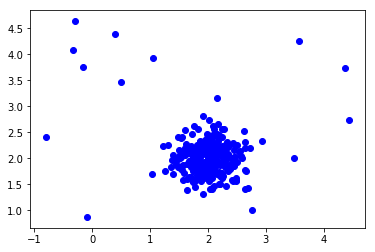

In [18]:
def make_blob_dataset(n_samples, contamination=0.05, random_state=42):
    rng = np.random.RandomState(random_state)
    X_inliers = 0.3 * rng.normal(size=(int(n_samples * (1. - contamination)), 2)) + 2
    X_outliers = rng.uniform(low=-1, high=5, size=(int(n_samples * contamination), 2))
    X = np.concatenate((X_inliers, X_outliers), axis=0)
    rng.shuffle(X)
    return X

X = make_blob_dataset(300)
plt.scatter(X[:, 0], X[:, 1], color='b');

<div class="alert alert-success">
    <b>QUESTION 10:</b>
     <ul>
      <li>Update your kernel function so it computes the Gaussian kernel:
      
        $$
            K(x_i, x_j) = \exp(-\gamma \| x_i - x_j \|^2)
        $$

        where $\gamma > 0$ is the kernel bandwidth.
      </li>
    </ul>
</div>

In [19]:
# TODO

from scipy import linalg

def rbf_kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    gamma = .3
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.exp(-gamma*linalg.norm(a=X1[i]-X2[j], ord=2)**2)  # CHANGE THIS
    return K

Using the change above the follwing code should allow you to nicely separate the dense region from the outliers

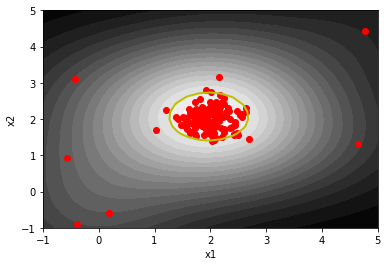

In [20]:
X = make_blob_dataset(150)

K = rbf_kernel(X, X)
mu_support, idx_support = ocsvm_solver(K, nu=0.1)
rho = compute_rho(K, mu_support, idx_support)

plot_ocsvm(X, mu_support, idx_support, rho, kernel=rbf_kernel)

## Part 2: One-class SVM without $\rho$

Formulation for example used in:

```
Consistency of one-class SVM and related algorithms
Régis Vert and Jean-philippe Vert
NIPS 2006
```

The problem of the formuation of SVMs with the variable $\rho$ is that
it leads to an annoying constraint in the dual, namely the $\mu^{\top}1_n = 1$.

We will now see what we can do about it.

Let's consider the problem

$$
	\begin{aligned}
	\min_{w, \xi} & \quad \frac{1}{2}\Vert w \Vert^2 + \frac{C}{n} \sum_{i=1}^n \xi_i \\
	\text{s.t.} & \quad \langle w, x_i \rangle \geq 1 - \xi_i \quad 1 \leq i \leq n \\
	& \quad \xi_i \geq 0 \quad 1 \leq i \leq n
	\end{aligned}
$$

<div class="alert alert-success">
    <b>QUESTION 10:</b>
     <ul>
      <li>Show that a dual problem of this problem is given by:
      
        $$
        (\mathcal{D}):
            \left\{
            \begin{array}{lll}
            \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
            \\
            \mathrm{s.t.}& 0 \leq \mu \leq \frac{C}{n}
            \end{array}
            \right .
        $$
      </li>
    </ul>
</div>

ANSWER HERE

We first write out the Lagrangian Formular for the problem P:

$L(w, \xi, \phi_{1i}, \phi_{2i} \quad; 1 \leq i \leq n ) = $

$\quad \frac{1}{2}\Vert w \Vert^2 + \frac{1}{\nu n} \sum_{i=1}^n \xi_i + \sum_{i=1}^n \phi_{1i} ( 1 - \xi_i - \langle w, x_i \rangle ) - \sum_{i=1}^n \phi_{2i} \xi_i - \iota_{R_+}(\phi_1, \phi_2) $

Now we can write our problem D as following:

$$ 
\max_{\phi_{1i}, \phi_{2i}} \min_{w, \xi_i}
\quad \frac{1}{2}\Vert w \Vert^2 + \frac{C}{n} \sum_{i=1}^n \xi_i + \sum_{i=1}^n \phi_{1i} ( 1 - \xi_i - \langle w, x_i \rangle ) - \sum_{i=1}^n \phi_{2i} \xi_i - \iota_{R_+}(\phi_1, \phi_2)
\\
$$

We then list all the derivatives with respect to variables $w, \xi_i$ :
$$
\partial_{w} L(w, \rho, \xi, \phi_{1i}, \phi_{2i}) = w - \sum_{i=1}^n \phi_{1i} x_{i} = 0
\\
\partial_{\xi_i} L(w, \rho, \xi, \phi_{1i}, \phi_{2i}) = \frac{C}{n} - \phi_{1i} - \phi_{2i} = 0
$$

Let $\mu = \phi_1$, and use the above two equalities in the problem D:

$$ 
\max_{\phi_{1i}, \phi_{2i}}
\quad \frac{1}{2}\Vert \sum_{i=1}^n \phi_{1i} x_{i} \Vert^2 + \sum_{i=1}^n (\frac{C}{n} - \phi_{1i} - \phi_{2i}) \xi_i + \sum_{i=1}^n \phi_{1i} ( 1 - \langle w, x_i \rangle ) - \iota_{R_+}(\phi_1, \phi_2)
\\
$$

which is equal to 

$$
(\mathcal{D}):
    \left\{
    \begin{array}{lll}
    \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
    \\
    \mathrm{s.t.}& 0 \leq \mu \leq \frac{C}{n}
    \end{array}
    \right .
$$

<div class="alert alert-success">
    <b>QUESTION 11:</b>
     <ul>
      <li> Rewrite the dual in the form:
      
            $$
            (\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
            $$

            where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ is a non-smooth function that is separable, namely:

            $$
            g(\mu) = \sum_{i=1}^n g_i(\mu_i)
            $$
      </li>
    </ul>
</div>



ANSWER HERE

$$
\min_{\mu} \frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n + \sum_{i=1}^n ( \iota_{R_{+}^n}(\mu_i) + \iota_{R_{+}^n}(\frac{C}{n} - \mu_i))
$$

The dual in the later form can be readily optimized using the methods that you have been studying in this class:

- Proximal gradient method with and without acceleration
- L-BFGS-B
- Coordinate descent

## Proximal gradient method without acceleration

In [69]:
%%time

def prox_non_acc(C, X, gram, max_iter = 5000, verbose=True, callback=None, **params):
    
    def Lip_square_(A):
        return np.linalg.norm(x=A, ord=2)
    
    n = X.shape[0]
    
    # initialize parameter
    mu = np.random.rand(n)
    threshold = C / n
    L = Lip_square_(gram)
    
    for i in range(max_iter):
        mu_old = mu.copy()
        grad_g = gram.dot(mu)-np.ones(n)
        # gradient desecent for function g
        mu_temp = mu - 1/L * grad_g

        # projection step: proxf
        idx1 = mu_temp < 0
        idx2 = mu_temp > threshold
        mu_temp[idx1] = 0
        mu_temp[idx2] = threshold
        
        mu = mu_temp
        error = np.linalg.norm(x=mu_old-mu, ord=2)
        obj = 1/2 * mu.dot(K).dot(mu) - mu.dot(np.ones(n))
        # store some values
        callback(error, mu, obj, params["dictionary"])
        
        if verbose:
            print("step", i, "error = ", error, "obj =", obj)
        
        if  error < 1e-5 :
            print(mu[mu>1e-5], np.arange(len(mu))[mu>1e-5])
            break
            
    return mu


dic = {"lis_err": [], "lis_mu": [], "lis_obj": []}
def cb(err, mu, obj, dic):
    dic["lis_err"].append(err)
    dic["lis_mu"].append(mu)
    dic["lis_obj"].append(obj)
    
mu_non_acc = prox_non_acc(C=10,X=X,gram=K, callback=cb, dictionary=dic)

#mu[mu>1e-5]

step 0 error =  6.82626898109 obj = 5.28145446592
step 1 error =  0.2217891701 obj = 0.510584944204
step 2 error =  0.104319632586 obj = -0.560761228526
step 3 error =  0.0522028280692 obj = -0.831046630544
step 4 error =  0.0272600277689 obj = -0.904950682233
step 5 error =  0.0144308041782 obj = -0.926092989184
step 6 error =  0.00822248732233 obj = -0.93320669698
step 7 error =  0.00532941234232 obj = -0.936438318971
step 8 error =  0.00421445887563 obj = -0.938625979909
step 9 error =  0.00387194919619 obj = -0.940541426111
step 10 error =  0.00377292051098 obj = -0.942379722894
step 11 error =  0.00373646274127 obj = -0.944187361347
step 12 error =  0.00371476296092 obj = -0.945975207726
step 13 error =  0.00369683086116 obj = -0.947746198232
step 14 error =  0.0036802596266 obj = -0.949501539694
step 15 error =  0.00366451178122 obj = -0.951242040707
step 16 error =  0.00364944120951 obj = -0.952968388386
step 17 error =  0.00363496220547 obj = -0.954681182668
step 18 error =  0.

In [81]:
import matplotlib.pyplot as plt

## Proximal gradient method with acceleration

In [71]:
%%time

def prox_acc(C, X, gram, max_iter=5000, verbose=True, callback=None, **params):
    
    def Lip_square_(A):
        return np.linalg.norm(x=A, ord=2)
    
    n = X.shape[0]
    
    # initialize parameter
    mu = np.random.rand(n)
    threshold = C / n
    L = Lip_square_(gram)
    
    def prox_grad(mu):
        grad_g = gram.dot(mu)-np.ones(n)
        # gradient desecent for function g
        mu_temp = mu - 1/L * grad_g
        # projection step: proxf
        idx1 = mu_temp < 0
        idx2 = mu_temp > threshold
        mu_temp[idx1] = 0
        mu_temp[idx2] = threshold
        return mu_temp
    
    # first time : do a normal prox_grad
    mu_old = mu.copy()
    mu = prox_grad(mu)
    
    for i in range(1, max_iter):
        # calculate v
        v = mu + i/(i+3) * (mu - mu_old)
        # do update
        mu_old = mu.copy()
        mu = prox_grad(v)
        
        error = np.linalg.norm(x=mu_old-mu, ord=2)
        obj = 1/2 * mu.dot(K).dot(mu) - mu.dot(np.ones(n))
        # store some values
        callback(error, mu, obj, params["dictionary"])
        
        if verbose:
            print("step", i, "error = ", error, "obj =", obj)
        
        if  error < 1e-5 :
            print(mu[mu>1e-5], np.arange(len(mu))[mu>1e-5])
            break
            
    return mu


dic_acc = {"lis_err": [], "lis_mu": [], "lis_obj": []}
    
mu_acc = prox_acc(C=10,X=X,gram=K, callback=cb, dictionary=dic_acc)

step 1 error =  0.631023298885 obj = 0.901985144058
step 2 error =  0.0937189199847 obj = 0.731200982476
step 3 error =  0.0771209878978 obj = -0.0128426074574
step 4 error =  0.0784377838216 obj = -0.47683091298
step 5 error =  0.0648729048013 obj = -0.686296385533
step 6 error =  0.0499233160912 obj = -0.785053306073
step 7 error =  0.0438364048979 obj = -0.860483859473
step 8 error =  0.0303746318285 obj = -0.901337636256
step 9 error =  0.0187003321664 obj = -0.91344593508
step 10 error =  0.017044821753 obj = -0.921496259985
step 11 error =  0.0168518203504 obj = -0.929598756748
step 12 error =  0.0169578710726 obj = -0.937633941905
step 13 error =  0.0172502600563 obj = -0.945696838039
step 14 error =  0.0176675077588 obj = -0.953865117927
step 15 error =  0.0171934061974 obj = -0.96165523617
step 16 error =  0.0154865169322 obj = -0.967470092202
step 17 error =  0.0154820306999 obj = -0.972960563402
step 18 error =  0.0150245164613 obj = -0.978047848176
step 19 error =  0.013036

-1.00571395149


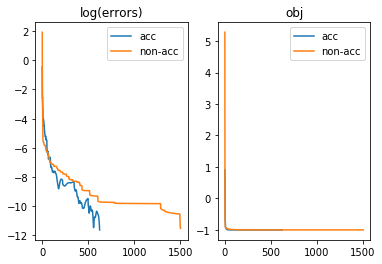

In [89]:
plt.subplot(1,2,1)
plt.plot(np.log(np.array(dic_acc["lis_err"])))
plt.plot(np.log(np.array(dic["lis_err"])))
plt.title("log(errors)")
plt.legend(["acc", "non-acc"])

plt.subplot(1,2,2)
plt.plot(np.array(dic_acc["lis_obj"]))
plt.plot(np.array(dic["lis_obj"]))
plt.title("obj")
plt.legend(["acc", "non-acc"])

# final minimum almost equal or not 
assert_almost_equal( dic_acc["lis_obj"][-1], dic["lis_obj"][-1], decimal=4)
print(dic_acc["lis_obj"][-1])

### We saw that the accelerated method has a faster convergent speed (3 times faster according to the cell execution time)

In [73]:
mu_non_acc[mu_non_acc > 1e-5], mu_acc[mu_acc > 1e-5]

(array([ 0.06711409,  0.06711409,  0.06711409,  0.06711409,  0.00809177,
         0.06711409,  0.06711409,  0.06711409,  0.06711409,  0.02574164,
         0.06711409,  0.06711409,  0.01333879,  0.06711409,  0.06711409,
         0.06711409,  0.06711409,  0.06711409,  0.00945531,  0.06711409,
         0.06711409,  0.06711409,  0.06711409,  0.06711409,  0.03999934,
         0.06711409,  0.06711409,  0.06711409]),
 array([ 0.06711409,  0.06711409,  0.06711409,  0.06711409,  0.06711409,
         0.06711409,  0.06711409,  0.06711409,  0.06189317,  0.06711409,
         0.06711409,  0.02480039,  0.06711409,  0.06711409,  0.06711409,
         0.06711409,  0.06711409,  0.00948978,  0.06711409,  0.06711409,
         0.06711409,  0.06711409,  0.06711409,  0.06711409,  0.06711409,
         0.06711409]))

## Coordinate descent

$$
\min_{\mu} \frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n + \sum_{i=1}^n ( \iota_{R_{+}^n}(\mu_i) + \iota_{R_{+}^n}(\frac{C}{n} - \mu_i))
$$


In [106]:
%%time

def coordinate(C, X, gram, max_iter=3000, verbose=True, callback=None, **params):
    # first compute the gradient of f(u) w.r.t u_i
    
    n = X.shape[0]
    
    # initialize parameter
    mu = np.random.rand(n)
    threshold = C / n
    
    def Lip_square_(A):
        return np.linalg.norm(x=A, ord=2)
    
    L_lis = [ Lip_square_(gram[cor]) for cor in range(n) ]
    
    for i in range(max_iter):
        mu_old = mu.copy()
        
        for cor in range(n):
            # optimizing each coordiante
            # generating K_{i,-i} and u_{i,-i}
            L = L_lis[cor]
            grad_f = K[cor].dot(mu) - 1
            temp = mu[cor] - grad_f * 1/L
            
            # projection step: proxf
            if temp < 0:
                temp = 0
            elif temp > threshold:
                temp = threshold
            
            mu[cor] = temp

        error = linalg.norm(a=mu-mu_old, ord=2)
        obj = 1/2 * mu.dot(K).dot(mu) - mu.dot(np.ones(n))
        # store some values
        callback(error, mu, obj, params["dictionary"])
        
        if verbose:
            print("time", i,"err = ", error)

        if error < 1e-5:
            break

    return mu

dic_coo = {"lis_err": [], "lis_mu": [], "lis_obj": []}
mu_c =  coordinate(C=10, X=X, gram=K, verbose=True, callback=cb, dictionary=dic_coo) 
mu_c[mu>1e-5]

time 0 err =  6.8004026719575625
time 1 err =  0.15034117505059935
time 2 err =  0.03924422858066079
time 3 err =  0.03550585991145558
time 4 err =  0.03398474607246284
time 5 err =  0.024254518951536734
time 6 err =  0.023103675787168893
time 7 err =  0.02273877436341615
time 8 err =  0.02033958620012866
time 9 err =  0.019003561546937667
time 10 err =  0.018066508262778887
time 11 err =  0.017921830136019116
time 12 err =  0.017330275946455444
time 13 err =  0.015217537461978117
time 14 err =  0.01422307557096574
time 15 err =  0.011844295414115032
time 16 err =  0.011791676249988411
time 17 err =  0.009923009980425933
time 18 err =  0.007903271898348888
time 19 err =  0.007196465973966806
time 20 err =  0.005460694445485111
time 21 err =  0.005334231040587545
time 22 err =  0.00507503144465907
time 23 err =  0.0048974245156474154
time 24 err =  0.004633651346828594
time 25 err =  0.00456949808292008
time 26 err =  0.004529705058927934
time 27 err =  0.004501667688298545
time 28 err 

-1.00571397418


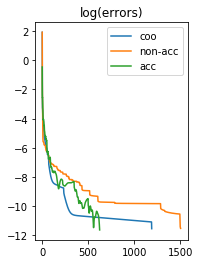

In [107]:
plt.subplot(1,2,1)
plt.plot(np.log(np.array(dic_coo["lis_err"])))
plt.plot(np.log(np.array(dic["lis_err"])))
plt.plot(np.log(np.array(dic_acc["lis_err"])))
plt.title("log(errors)")
plt.legend(["coo", "non-acc", "acc"])

assert_almost_equal(dic_coo["lis_obj"][-1], dic["lis_obj"][-1], decimal=4)
print(dic_coo["lis_obj"][-1])

### in terms of computation time, at the first stage, the Coordinate descent algorithm is much faster than both the accelerated and non-accelerated ones, yet when executed time is long (or more close to the fix point/ convergence point), the coordinate algo performs worse than accelerated proximal gradient descent algorithm, yet it is better or very close to non-accelerated proximal gradient descent. 

## BFGS

In [18]:
# TODO

from scipy.optimize import fmin_l_bfgs_b

In [150]:
%%time 

class bfgs:

    def __init__(self, C=10):
        self.C = C
        self.mu = None
        self.final_obj = 0
        self.all_x = []
        self.all_loss = []
        self.loss = 0
        self.time = 0


    def func(self, params, *args):
        # compute loss function
        # args
        K = args
        # parameters
        mu = params
        K = np.asarray(K)
        # computing loss function
        self.loss = 1/2 * mu.T.dot(K).dot(mu)-np.sum(mu)
        
        return self.loss

    def func_grad(self,params,*args):
        # compute gradient function

        # args
        K = args
        # parameters
        mu = params

        K = np.asarray(K)

        N_sample, _ = K.shape

        gradient = np.dot(K,mu) - np.ones(N_sample)

        return gradient

    def callfunc(self, x):
        self.all_x.append(x.copy())
        self.all_loss.append(self.loss)
        self.time += 1
        print("iteration time = ", self.time, "loss =", self.loss)
    
    
    def fit(self,X,K):
        # initialize parameters
        N_sample = X.shape[0]

        mu = np.random.rand(N_sample)

        threshold = self.C / N_sample

        # setting the range
        interval = np.zeros([N_sample,2])

        interval[:,1]= threshold

        para_optimal, self.final_obj, info = fmin_l_bfgs_b(self.func,x0=mu,fprime=self.func_grad,args=K,
                                        approx_grad=False,bounds=interval,maxiter=6000, factr=10.0, callback=self.callfunc)
        self.mu = para_optimal

        return para_optimal



clf = bfgs()
mu = clf.fit(X,K)
print(mu[mu>1e-5])

clf.all_loss

iteration time =  1 loss = -0.190613739518
iteration time =  2 loss = -0.775997976908
iteration time =  3 loss = -0.868096277885
iteration time =  4 loss = -0.886684241618
iteration time =  5 loss = -0.958810569892
iteration time =  6 loss = -0.973391978886
iteration time =  7 loss = -0.976926332312
iteration time =  8 loss = -0.979596751526
iteration time =  9 loss = -0.983735722024
iteration time =  10 loss = -0.989062047112
iteration time =  11 loss = -0.992076417914
iteration time =  12 loss = -0.995381932331
iteration time =  13 loss = -0.996975389564
iteration time =  14 loss = -0.998672885012
iteration time =  15 loss = -0.999377137131
iteration time =  16 loss = -1.00089175928
iteration time =  17 loss = -1.00125344982
iteration time =  18 loss = -1.00138957721
iteration time =  19 loss = -1.00183377139
iteration time =  20 loss = -1.00308134824
iteration time =  21 loss = -1.00359626954
iteration time =  22 loss = -1.00408186845
iteration time =  23 loss = -1.00461862634
itera

-1.00571399595


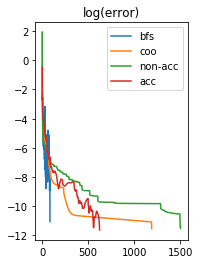

In [151]:
arr = linalg.norm(a=np.array(clf.all_x[1:]) - np.array(clf.all_x[:-1]), ord=2, keepdims=1,axis=1) 
plt.subplot(1,2,1)
plt.plot(np.log(arr))
plt.plot(np.log(np.array(dic_coo["lis_err"])))
plt.plot(np.log(np.array(dic["lis_err"])))
plt.plot(np.log(np.array(dic_acc["lis_err"])))
plt.title("log(error)")
plt.legend(['bfs',"coo", "non-acc", "acc"])

assert_almost_equal(clf.final_obj, dic["lis_obj"][-1], decimal=4)
print(clf.final_obj)

### L-BFGS-B outperforms the others, both in the execute time and the iterations

## own solver

$$
(\mathcal{D}):
    \left\{
    \begin{array}{lll}
    \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
    \\
    \mathrm{s.t.}& 0 \leq \mu \leq \frac{C}{n}
    \end{array}
    \right .
$$

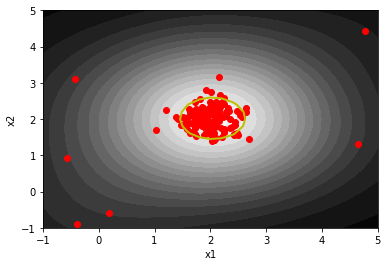

In [163]:
def qp_2(P, q, C, verbose=True):
    # Gram matrix
    n = P.shape[0]
    P = cvxopt.matrix(P)
    q = cvxopt.matrix(q)
    
    # as the qp take Gx < h
    G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                     np.diag(np.ones(n))], axis=0))
    h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(P, q, G, h, solver='mosec')
 
    return np.ravel(solution['x'])


def ocsvm_solver_2(K, r_c=10):
    n = np.shape(K)[0]
    P = K
    q = -1.0* np.ones(n)
    A = [] #np.zeros(n).reshape(1,-1)
    b = []
    C = r_c/n
    mu = qp_2(P, q, C, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

mu_support, idx_support = ocsvm_solver_2(K,r_c=10.0)
rho = compute_rho(K,mu_support,idx_support)
plot_ocsvm(X, mu_support, idx_support, rho, kernel=rbf_kernel)

<div class="alert alert-success">
    <b>QUESTION 12:</b>
    Implement:
     <ul>
      <li> your own solver based on the QP function in cvxopt (reuse `qp` function above).</li>
      <li> your own solver of proximal gradient with and without acceleration</li>
      <li> your own version of coordinate descent</li>
      <li> an L-BFGS-B solver using `scipy.optimize.fmin_l_bfgs_b`</li>
    </ul>
</div>

You will test your implementations on the Gaussian blob corrupted with some uniform noise obtained with `make_blob_dataset` function.

You will make sure that all solvers converge towards the same minimum !

You will evaluate the performance of your implementations in terms of computation time on problems where the matrix $G G^\top$ can fit in memory on your machine.

You should reuse as much as possible the convergence evaluation code that you used during the labs.

**Remark:** For the coordinate descent method there exist some smart updates provided you use a linear kernel.

**BONUS (Hard):** Explain without implementing it how such smart updates could work for the coordinate descent solver.

**IMPORTANT : This question 12 is the most important and will constitute half of the final grade on the project !**